# CS440/ECE448 Spring 2023
# MP11: Reinforcement Learning

The first thing you need to do is to download this file: <a href="mp11.zip">mp11.zip</a>.  If you want, you can also download <a href="mp11_extra.zip">mp11_extra.zip</a>, the extra credit assignment.  `mp11.zip` has the following content:

* `submitted.py`: Your homework. Edit, and then submit to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.
* `mp11_notebook.ipynb`: This is a <a href="https://anaconda.org/anaconda/jupyter">Jupyter</a> notebook to help you debug.  You can completely ignore it if you want, although you might find that it gives you useful instructions.
* `pong.py`: This is a program that plays Pong.  If called interactively, it will call the module `pong_display.py` to create a display, so that you can play.  If told to use a Q-learner, it will call your `submitted.py` to do Q-learning.
* `grade.py`: Once your homework seems to be working, you can test it by typing `python grade.py`, which will run the tests in `tests/tests_visible.py`.
* `tests/test_visible.py`: This file contains about half of the <a href="https://docs.python.org/3/library/unittest.html">unit tests</a> that Gradescope will run in order to grade your homework.  If you can get a perfect score on these tests, then you should also get a perfect score on the additional hidden tests that Gradescope uses.
* `requirements.txt`: This tells you which python packages you need to have installed, in order to run `grade.py`.  You can install all of those packages by typing `pip install -r requirements.txt` or `pip3 install -r requirements.txt`.

This file (`mp11_notebook.ipynb`) will walk you through the whole MP, giving you instructions and debugging tips as you go.

### Table of Contents

1. <a href="#section1">Playing Pong</a>
1. <a href="#section2">Creating a Q-Learner Object</a>
1. <a href="#section3">Epsilon-First Exploration</a>
1. <a href="#section4">Q-Learning</a>
1. <a href="#section5">Saving and Loading Your Q and N Tables</a>
1. <a href="#section6">Exploitation</a>
1. <a href="#section7">Acting</a>
1. <a href="#section8">Training</a>
1. <a href="#section9">Extra Credit</a>
1. <a href="#grade">Grade Your Homework</a>

<a id='section1'></a>

## Playing Pong

Pong was the <a href="https://en.wikipedia.org/wiki/Pong">first video game produced by Atari.</a>  It is a simple game, based on table tennis.  Here is a two-person version of the game: https://commons.wikimedia.org/wiki/File:Pong_Game_Test2.gif

We will be playing a one-person version of the game:

* When the ball hits the top, bottom, or left wall of the playing field, it bounces.
* The right end of the playing field is open, except for the paddle.  If the ball hits the paddle, it bounces, and the player's score increments by one.  If the ball hits the open space, the game is over; the score resets to zero, and a new game begins.

The game is pretty simple, but in order to get a better feeling for it, you may want to try playing it yourself.  Use the up arrow to move the paddle upward, and the down arrow to move the paddle downward.  See how high you can make your score:


In [1]:
!python pong.py

pygame 2.3.0 (SDL 2.24.2, Python 3.10.11)
Hello from the pygame community. https://www.pygame.org/contribute.html
Completed 0 games, 1 rewards, 182 frames, score 0, max score 0


Once you figure out how to use the arrow keys to control your paddle, we hope you will find that the game is not too hard for a human to play.  However, for a computer, it's difficult to know: where should the paddle be moved at each time step?  In order to see how difficult it is for a computer to play, let's ask the "random" player to play the game.

**WARNING:** The following line will open a pygame window.  The pygame window will be hidden by this window -- in order to see it, you will need to minimize this window.  The pygame window will consume a lot of CPU time just waiting for the processor, so in order to kill it, you will need to come back to this window, click on the block below, then click the Jupyter "stop" button (the square button at the top of this window) in order to stop processing.

In [3]:
!python pong.py --player random

<a id='section2'></a>

## Creating a Q-Learner Object

The first thing you will do is to create a `q_learner` object that can store your learned Q table and your N table (table of exploration counts).  

Like any other object-oriented language, python permits you to create new object classes in order to store data that will be needed from time to time.  If you are not already very, very familiar with python classes, you might want to study the python class tutorial: https://docs.python.org/3/tutorial/classes.html

Like any other object in python, a `q_learner` object is created by calling its name as a function, e.g., `my_q_learner=submitted.q_learner()`.  Doing so calls the function `submitted.q_learner.__init__()`.  Let's look at the docstring to see what it should do.

In [4]:
import submitted, importlib
importlib.reload(submitted)
help(submitted.q_learner.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst, state_cardinality)
    Create a new q_learner object.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a Q table and an N table.
    Q[...state..., ...action...] = expected utility of state/action pair.
    N[...state..., ...action...] = # times state/action has been explored.
    Both are initialized to all zeros.
    Up to you: how will you encode the state and action in order to
    define these two lookup tables?  The state will be a list of 5 integers,
    such that 0 <= state[i] < state_cardinality[i] for 0 <= i < 5.
    The action will be either -1, 0, or 1.
    It is up to you to decide how to convert an input state and action
    into indices that you can use to access your stored Q and N tables.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of takin

Write your `__init__` function to meet the requirements specified in the docstring.  Once you have completed it, the following code should run without errors:

In [6]:
importlib.reload(submitted)

q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])

print(q_learner)


<a id='section3'></a>

## Epsilon-First Exploration

In order to manage the exploration/exploitation tradeoff, we will be using both "epsilon-first" and "epsilon-greedy" (https://en.wikipedia.org/wiki/Multi-armed_bandit#Semi-uniform_strategies).  

The epsilon-first strategy explores every state/action pair at least `nfirst` times before it ever starts to exploit any strategy.  Your `q_learner` should have a table to keep track of how many times it has explored a state/action pair prior to the start of any exploitation.  The method for storing that table is up to you; in order to have some standardized API, therefore, you need to write a method called `report_exploration_counts` that returns a list of the three exploration counts for a given state. 

In [7]:
importlib.reload(submitted)
help(submitted.q_learner.report_exploration_counts)

Help on function report_exploration_counts in module submitted:

report_exploration_counts(self, state)
    Check to see how many times each action has been explored in this state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    explored_count (array of 3 ints): 
      number of times that each action has been explored from this state.
      The mapping from actions to integers is up to you, but there must be three of them.



Write `report_exploration_counts` so that it returns a list or array for any given state.  Test your code with the following:

In [15]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('This is how many times state [0,0,0,0,0] has been explored so far:')
print(q_learner.report_exploration_counts([0,0,0,0,0]))
print('This is how many times state [9,9,1,1,9] has been explored so far:')
print(q_learner.report_exploration_counts([9,9,1,1,9]))

This is how many times state [0,0,0,0,0] has been explored so far:
[0, 0, 0]
This is how many times state [9,9,1,1,9] has been explored so far:
[0, 0, 0]


When your learner first starts learning, it will call the function `choose_unexplored_action` to choose an unexplored action.  This function should choose a function uniformly at random from the set of unexplored actions in a given state, if there are any:

In [16]:
importlib.reload(submitted)
help(submitted.q_learner.choose_unexplored_action)

Help on function choose_unexplored_action in module submitted:

choose_unexplored_action(self, state)
    Choose an action that has been explored less than nfirst times.
    If many actions are underexplored, you should choose uniformly
    from among those actions; don't just choose the first one all
    the time.
    
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar): either -1, or 0, or 1, or None
      If all actions have been explored at least n_explore times, return None.
      Otherwise, choose one uniformly at random from those w/count less than n_explore.
      When you choose an action, you should increment its count in your counter table.



If this has been written correctly, the following block should generate a random sequence of actions.  If the next block produces the same action 5 times in a row, that is the wrong result, and the result would be that your code does not pass the autograder.

In [20]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: 0
Next action: 1
Next action: 0
Next action: 0
Next action: 1


After all three actions have been explored `nfirst` times, the function `choose_unexplored_action` should return `None`, as shown here:

In [21]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,1,[10,10,2,2,10])
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))
print('Next action:',q_learner.choose_unexplored_action([9,9,1,1,9]))


Next action: -1
Next action: 0
Next action: 1
Next action: None


<a id='section4'></a>

## Q-Learning

The reinforcement learning we are implementing is called Q-learning (https://en.wikipedia.org/wiki/Q-learning).  

Q-learning keeps a table $Q[s,a]$ that specifies the expected utility of action $a$ in state $s$.  The organization of this table is up to you.  In order to have a standard API, the first thing you should implement is a function `report_q` with the following docstring:

In [22]:
importlib.reload(submitted)
help(submitted.q_learner.report_q)

Help on function report_q in module submitted:

report_q(self, state)
    Report the current Q values for the given state.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q (array of 3 floats): 
      reward plus expected future utility of each of the three actions. 
      The mapping from actions to integers is up to you, but there must be three of them.



When your `q_learner` is first initialized, the value of $Q[state,action]$ should be zero for all state/action pairs, thus the `report_q` function should return lists of zeros:

In [23]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Q[0,0,0,0,0] is now:',q_learner.report_q([0,0,0,0,0]))
print('Q[9,9,1,1,9] is now:',q_learner.report_q([9,9,1,1,9]))

Q[0,0,0,0,0] is now: [0.0, 0.0, 0.0]
Q[9,9,1,1,9] is now: [0.0, 0.0, 0.0]


There are actually many different Q-learning algorithms available, but when people refer to Q-learning with no modifier, they usually mean the time-difference (TD) algorithm.  For example, this is the algorithm that's described on the wikipedia page (https://en.wikipedia.org/wiki/Q-learning).  This is the algorithm you will implement for this MP.

In supervised machine learning, the learner tries to imitate a reference label.  In reinforcement learning, there is no reference label.  Q-learning replaces the reference label with a "local Q" value, which is the utility that was obtained by performing action $a$ in state $s$ one time.  It is usually calculated like this:

$$Q_{local}(s_t,a_t) = r_t + \gamma\max_{a_{t+1}}Q(s_{t+1},a_{t+1})$$

where $r_t$ is the reward that was achieved by performing action $a_t$ in state $s_t$, $s_{t+1}$ is the state into which the game transitioned, and $a_{t+1}$ is one of the actions that could be performed in that state.  $Q_{local}$ is computed by your `q_local` function, which has this docstring:  

In [24]:
importlib.reload(submitted)
help(submitted.q_learner.q_local)

Help on function q_local in module submitted:

q_local(self, reward, newstate)
    The update to Q estimated from a single step of game play:
    reward plus gamma times the max of Q[newstate, ...].
    
    @param:
    reward (scalar float): the reward achieved from the current step of game play.
    newstate (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    Q_local (scalar float): the local value of Q



Initially, `q_local` should just return the given reward, because initially, all Q values are 0:

In [25]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,10,10])
print('Q_local(6.25,[9,9,1,1,9]) is currently:',q_learner.q_local(6.25,[9,9,1,1,9]))

Q_local(6.25,[9,9,1,1,9]) is currently: 6.25


Now you can use `q_learner.q_local` as the target for `q_learner.learn`.  The basic algorithm is

$$Q(s,a) = Q(s,a) + \alpha (Q_{local}(s,a)-Q(s,a))$$

Here is the docstring:

In [26]:
importlib.reload(submitted)
help(submitted.q_learner.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Update the internal Q-table on the basis of an observed
    state, action, reward, newstate sequence.
    
    @params:
    state: a list of 5 numbers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle.
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 numbers, in the same format as state
    
    @return:
    None



The following block checks a sequence of Q updates:

1. First, $Q([9,9,1,1,9],-1)$ is updated.  Since all Q values start at zero, it will be updated to just have a value equal to $\alpha$ (0.05) times the given reward (6.25) for a total value of 0.3125.
1. When we print out $Q([9,9,1,1,9],:)$, we see that one of the elements has been updated.
1. Next, update $Q([9,9,1,1,8],1)$ with a given reward, and with $[9,9,1,1,9]$ as the given next state.  Since $Q([9,9,1,1,9],-1)$ is larger than zero, the next-state Q-value should be multiplied by $\gamma$ (0.99) and added to the reward (3.1), then multiplied by $\alpha$, giving a total value of 0.17046875.
1. The resulting Q-value is reported.

In [31]:
importlib.reload(submitted)
q_learner = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q[9,9,1,1,9] is now',q_learner.report_q([9,9,1,1,9]))
q_learner.learn([9,9,1,1,8],1,3.1,[9,9,1,1,9])
print('Q[9,9,1,1,8] is now',q_learner.report_q([9,9,1,1,8]))

Q[9,9,1,1,9] is now [0.3125, 0.0, 0.0]
Q[9,9,1,1,8] is now [0.0, 0.0, 0.17046875000000003]


<a id='section5'></a>

## Saving and Loading your Q and N Tables

After you've spent a long time training your `q_learner`, you will want to save your Q and N tables so that you can reload them later.  The format of Q and N is up to you, therefore it's also up to you to write the `save` and `load` functions.  Here are the docstrings:

In [32]:
importlib.reload(submitted)
help(submitted.q_learner.save)

Help on function save in module submitted:

save(self, filename)
    Save your Q and N tables to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.  We recommend numpy.savez,
    but you can use something else if you prefer.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [33]:
importlib.reload(submitted)
help(submitted.q_learner.load)

Help on function load in module submitted:

load(self, filename)
    Load the Q and N tables from a file.
    This should load from whatever file format your save function
    used.  We recommend numpy.load, but you can use something
    else if you prefer.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



These functions can be tested by doing one step of training one `q_learner`, then saving its results, then loading them into another `q_learner`:

In [34]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('Next action:',q_learner1.choose_unexplored_action([9,9,1,1,9]))
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('N1[9,9,1,1,8] is now',q_learner1.report_exploration_counts([9,9,1,1,9]))
print('Q1[9,9,1,1,8] is now',q_learner1.report_q([9,9,1,1,9]))
q_learner1.save('test.npz')

q_learner2 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
print('N2[9,9,1,1,8] starts out as',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] starts out as',q_learner2.report_q([9,9,1,1,9]))
q_learner2.load('test.npz')
print('N2[9,9,1,1,8] is now',q_learner2.report_exploration_counts([9,9,1,1,9]))
print('Q2[9,9,1,1,8] is now',q_learner2.report_q([9,9,1,1,9]))


Next action: -1
N1[9,9,1,1,8] is now [1, 0, 0]
Q1[9,9,1,1,8] is now [0.3125, 0.0, 0.0]
N2[9,9,1,1,8] starts out as [0, 0, 0]
Q2[9,9,1,1,8] starts out as [0.0, 0.0, 0.0]
N2[9,9,1,1,8] is now [1, 0, 0]
Q2[9,9,1,1,8] is now [0.3125, 0.0, 0.0]


<a id='section6'></a>

## Exploitation

A reinforcement learner always has to trade off between exploration (choosing an action at random) versus exploitation (choosing the action with the maximum expected utility).  Before we worry about that tradeoff, though, let's first make sure that exploitation works.

In [35]:
importlib.reload(submitted)
help(submitted.q_learner.exploit)

Help on function exploit in module submitted:

exploit(self, state)
    Return the action that has the highest Q-value for the current state, and its Q-value.
    @params:
    state (list of 5 ints): ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    action (scalar int): either -1, or 0, or 1.
      The action that has the highest Q-value.  Ties can be broken any way you want.
    Q (scalar float): 
      The Q-value of the selected action



In [36]:
importlib.reload(submitted)
q_learner1 = submitted.q_learner(0.05,0.05,0.99,5,[10,10,2,2,10])
q_learner1.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('Q1[9,9,1,1,9] is now',q_learner1.report_q([9,9,1,1,9]))
print('The best action and Q from state [9,9,1,1,9] are',q_learner1.exploit([9,9,1,1,9]))

Q1[9,9,1,1,9] is now [0.3125, 0.0, 0.0]
The best action and Q from state [9,9,1,1,9] are (-1, 0.3125)


<a id='section7'></a>

## Acting

When your learner decides which action to perform, it should trade off exploration vs. exploitation using both the epsilon-first and the epsilon-greedy strategies:
1. If there is any action that has been explored fewer than `nfirst` times, then choose one of those actions at random.  Otherwise...
1. With probability `epsilon`, choose an action at random.  Otherwise...
1. Exploit.


In [37]:
importlib.reload(submitted)
help(submitted.q_learner.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    If any action has been taken less than nfirst times, then choose one of those
    actions, uniformly at random.
    Otherwise, with probability epsilon, choose an action uniformly at random.
    Otherwise, choose the action with the best Q(state,action).
    
    @params: 
    state: a list of 5 integers: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
      These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
      and the y-position of the paddle, all quantized.
      0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In order to test all three types of action (epsilon-first exploration, epsilon-greedy exploration, and exploitation), let's create a learner with `nfirst=1` and `epsilon=0.25`, and set it so that the best action from state `[9,9,1,1,9]` is `-1`.  With these settings, a sequence of calls to `q_learner.act` should produce the following sequence of actions:

1. The first three actions should include each possible action once.
1. After the first three actions, 3/4 of the remaining actions should be `-1`.  The remaining 1/4 should be randomly chosen.

In [39]:
importlib.reload(submitted)
q_learner=submitted.q_learner(0.05,0.25,0.99,1,[10,10,2,2,10])
q_learner.learn([9,9,1,1,9],-1,6.25,[0,0,0,0,0])
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-first action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))
print('An epsilon-greedy explore/exploit action:',q_learner.act([9,9,1,1,9]))

An epsilon-first action: 1
An epsilon-first action: 0
An epsilon-first action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: 0
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1
An epsilon-greedy explore/exploit action: -1


<a id='section8'></a>

## Training

Now that all of your components work, you can try training your algorithm.  Do this by giving your `q_learner` as a player to a new `pong.PongGame` object.  Set `visibility=False` so that the `PongGame` doesn't create a new window.

In [51]:
import pong, importlib, submitted
importlib.reload(pong)
help(pong.PongGame.__init__)

Help on function __init__ in module pong:

__init__(self, ball_speed=4, paddle_speed=8, learner=None, visible=True, state_quantization=[10, 10, 2, 2, 10])
    Create a new pong game, with a specified player.
    
    @params:
    ball_speed (scalar int) - average ball speed in pixels/frame
    paddle_speed (scalar int) - paddle moves 0, +paddle_speed, or -paddle_speed
    learner - can be None if the player is human.  If not None, should be an 
      object of type random_learner, submitted.q_learner, or submitted.deep_q.
    visible (bool) - should this game have an attached pygame window?
    state_quantization (list) - if not None, state variables are quantized
      into integers of these cardinalities before being passed to the learner.



As you can see, we should set `visibility=False` so that the `PongGame` doesn't create a new window.  We should also make sure that the PongGame uses the same state quantization as the learner.

In [52]:
importlib.reload(pong)
importlib.reload(submitted)
state_quantization = [10,10,2,2,10]
q_learner=submitted.q_learner(0.05,0.05,0.99,5,state_quantization)

pong_game = pong.PongGame(learner=q_learner, visible=False, state_quantization=state_quantization)
print(pong_game)

In order to train our learner, we want it to play the game many times.  To do that we use the PongGame.run function:

In [53]:
help(pong_game.run)


Help on method run in module pong:

run(m_rewards=inf, m_games=inf, m_frames=inf, states=[]) method of pong.PongGame instance
    Run the game.
    @param
    m_frames (scalar int): maximum number of frames to be played
    m_rewards (scalar int): maximum number of rewards earned (+ or -)
    m_games (scalar int): maximum number of games
    states (list): list of states whose Q-values should be returned
       each state is a list of 5 ints: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
       These are the (x,y) position of the ball, the (vx,vy) velocity of the ball,
       and the y-position of the paddle, all quantized.
       0 <= state[i] < state_cardinality[i], for all i in [0,4].
    
      
    @return
    scores (list): list of scores of all completed games
    
    The following will be returned only if the player is q_learning or deep_q.
    New elements will be added to these lists once/frame if m_frames is specified,
    else once/reward if m_rewards is specified, else once

In order to make sure our learner is learning, let's tell `pong_game.run` to output all 3 Q-values of all of the 4000 states in every time step.

To make sure that's not an outrageous amount of data, let's tell it to only output the Q values once/reward, and ask it to only collect 5000 rewards:


In [54]:
states = [[x,y,vx,vy,py] for x in range(10) for y in range(10) for vx in range(2) for vy in range(2) for py in range(10) ]

scores, q_achieved, q_states = pong_game.run(m_rewards=500, states=states)

print('The number of games played was',len(scores))
print('The number of rewards was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 2 rewards, 591 frames, score 1, max score 1
Completed 1 games, 3 rewards, 845 frames, score 0, max score 1
Completed 2 games, 5 rewards, 1435 frames, score 1, max score 1
Completed 3 games, 7 rewards, 2083 frames, score 1, max score 1
Completed 4 games, 9 rewards, 2580 frames, score 1, max score 1
Completed 5 games, 10 rewards, 2761 frames, score 0, max score 1
Completed 6 games, 12 rewards, 3189 frames, score 1, max score 1
Completed 7 games, 14 rewards, 3556 frames, score 1, max score 1
Completed 8 games, 15 rewards, 3764 frames, score 0, max score 1
Completed 9 games, 17 rewards, 4307 frames, score 1, max score 1
Completed 10 games, 18 rewards, 4561 frames, score 0, max score 1
Completed 11 games, 19 rewards, 4742 frames, score 0, max score 1
Completed 12 games, 23 rewards, 6037 frames, score 3, max score 3
Completed 13 games, 26 rewards, 6639 frames, score 2, max score 3
Completed 14 games, 28 rewards, 7076 frames, score 1, max score 3
Completed 15 games, 29 rewa

Completed 158 games, 251 rewards, 59066 frames, score 1, max score 6
Completed 159 games, 253 rewards, 59453 frames, score 1, max score 6
Completed 160 games, 254 rewards, 59634 frames, score 0, max score 6
Completed 161 games, 255 rewards, 59888 frames, score 0, max score 6
Completed 162 games, 256 rewards, 60142 frames, score 0, max score 6
Completed 163 games, 257 rewards, 60396 frames, score 0, max score 6
Completed 164 games, 258 rewards, 60650 frames, score 0, max score 6
Completed 165 games, 259 rewards, 60904 frames, score 0, max score 6
Completed 166 games, 260 rewards, 61158 frames, score 0, max score 6
Completed 167 games, 262 rewards, 61556 frames, score 1, max score 6
Completed 168 games, 263 rewards, 61810 frames, score 0, max score 6
Completed 169 games, 264 rewards, 61991 frames, score 0, max score 6
Completed 170 games, 266 rewards, 62542 frames, score 1, max score 6
Completed 171 games, 267 rewards, 62796 frames, score 0, max score 6
Completed 172 games, 268 rewards, 

The returned value of `q_states` is a list of 4000x3 numpy arrays (20 states, 3 actions).  The list contains `m_rewards` of these. We want to convert it into something that matplotlib can plot.  

In [55]:
import numpy as np

Q = np.array([np.reshape(q,-1) for q in q_states])
print('Q is now of shape',Q.shape)
print('the max absolute value of Q is ',np.amax(abs(Q)))

Q is now of shape (500, 12000)
the max absolute value of Q is  2.246615360586546


Text(0, 0.5, 'Reward number')

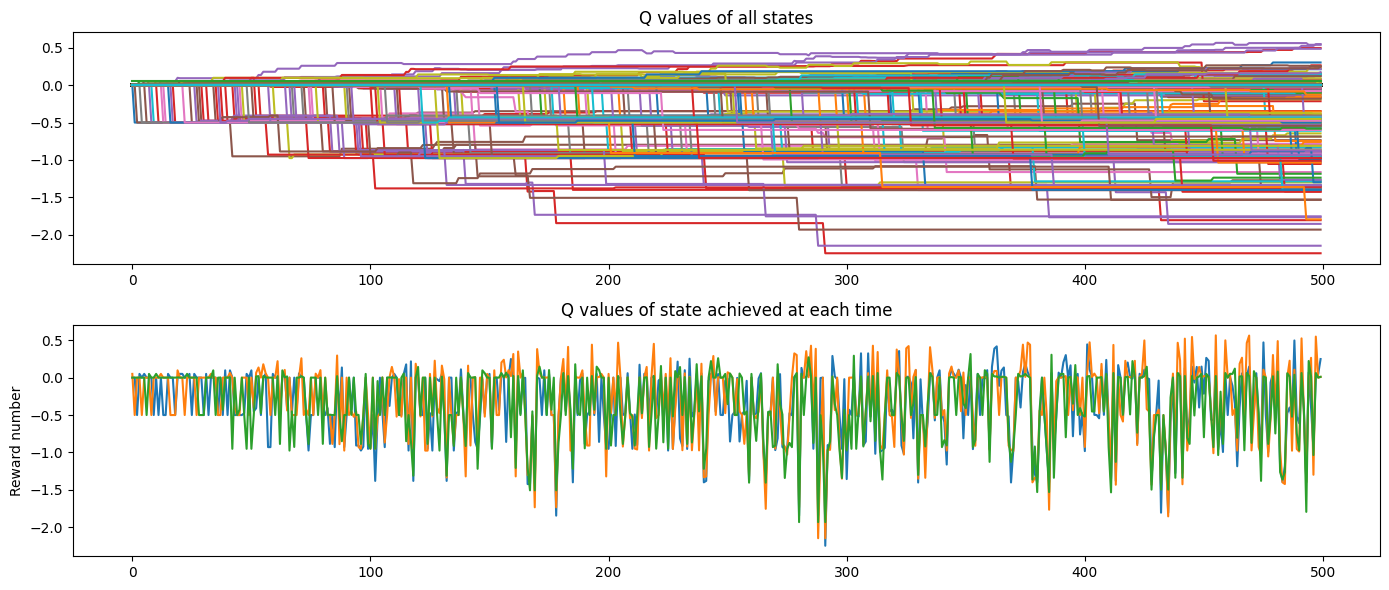

In [56]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,6),layout='tight')
ax = [ fig.add_subplot(2,1,x) for x in range(1,3) ]
ax[0].plot(np.arange(0,len(q_states)),Q)
ax[0].set_title('Q values of all states')
ax[1].plot(np.arange(0,len(q_states)),q_achieved)
ax[1].set_title('Q values of state achieved at each time')
ax[1].set_ylabel('Reward number')

OK, now let's try running it for a much longer period -- say, 5000 complete games.  We won't ask it to print out any states this time.

In [57]:
scores, q_achieved, q_states = pong_game.run(m_games=5000, states=[])

print('The number of games played was',len(scores))
print('The number of video frames was',len(q_states))
print('The size of each returned Q-matrix was',q_states[0].shape)


Completed 0 games, 1 rewards, 182 frames, score 3, max score 6
Completed 1 games, 7 rewards, 1123 frames, score 5, max score 6
Completed 2 games, 8 rewards, 1331 frames, score 0, max score 6
Completed 3 games, 9 rewards, 1539 frames, score 0, max score 6
Completed 4 games, 10 rewards, 1720 frames, score 0, max score 6
Completed 5 games, 14 rewards, 2503 frames, score 3, max score 6
Completed 6 games, 20 rewards, 3821 frames, score 5, max score 6
Completed 7 games, 23 rewards, 4335 frames, score 2, max score 6
Completed 8 games, 26 rewards, 6193 frames, score 2, max score 6
Completed 9 games, 30 rewards, 7389 frames, score 3, max score 6
Completed 10 games, 31 rewards, 7643 frames, score 0, max score 6
Completed 11 games, 33 rewards, 8041 frames, score 1, max score 6
Completed 12 games, 36 rewards, 8733 frames, score 2, max score 6
Completed 13 games, 37 rewards, 8941 frames, score 0, max score 6
Completed 14 games, 38 rewards, 9195 frames, score 0, max score 6
Completed 15 games, 44 re

Completed 122 games, 265 rewards, 65146 frames, score 3, max score 9
Completed 123 games, 269 rewards, 65775 frames, score 3, max score 9
Completed 124 games, 270 rewards, 65956 frames, score 0, max score 9
Completed 125 games, 271 rewards, 66137 frames, score 0, max score 9
Completed 126 games, 272 rewards, 66345 frames, score 0, max score 9
Completed 127 games, 274 rewards, 66896 frames, score 1, max score 9
Completed 128 games, 280 rewards, 67589 frames, score 5, max score 9
Completed 129 games, 281 rewards, 67843 frames, score 0, max score 9
Completed 130 games, 283 rewards, 68241 frames, score 1, max score 9
Completed 131 games, 285 rewards, 69160 frames, score 1, max score 9
Completed 132 games, 287 rewards, 69672 frames, score 1, max score 9
Completed 133 games, 288 rewards, 69926 frames, score 0, max score 9
Completed 134 games, 289 rewards, 70107 frames, score 0, max score 9
Completed 135 games, 290 rewards, 70361 frames, score 0, max score 9
Completed 136 games, 291 rewards, 

Completed 280 games, 634 rewards, 150492 frames, score 4, max score 9
Completed 281 games, 635 rewards, 150673 frames, score 0, max score 9
Completed 282 games, 636 rewards, 150854 frames, score 0, max score 9
Completed 283 games, 637 rewards, 151035 frames, score 0, max score 9
Completed 284 games, 638 rewards, 151243 frames, score 0, max score 9
Completed 285 games, 644 rewards, 152268 frames, score 5, max score 9
Completed 286 games, 647 rewards, 152759 frames, score 2, max score 9
Completed 287 games, 650 rewards, 153360 frames, score 2, max score 9
Completed 288 games, 654 rewards, 154348 frames, score 3, max score 9
Completed 289 games, 655 rewards, 154529 frames, score 0, max score 9
Completed 290 games, 656 rewards, 154710 frames, score 0, max score 9
Completed 291 games, 659 rewards, 155274 frames, score 2, max score 9
Completed 292 games, 660 rewards, 155528 frames, score 0, max score 9
Completed 293 games, 661 rewards, 155736 frames, score 0, max score 9
Completed 294 games,

Completed 452 games, 1054 rewards, 260991 frames, score 0, max score 12
Completed 453 games, 1059 rewards, 262019 frames, score 4, max score 12
Completed 454 games, 1065 rewards, 263264 frames, score 5, max score 12
Completed 455 games, 1066 rewards, 263472 frames, score 0, max score 12
Completed 456 games, 1068 rewards, 263969 frames, score 1, max score 12
Completed 457 games, 1072 rewards, 264698 frames, score 3, max score 12
Completed 458 games, 1073 rewards, 264879 frames, score 0, max score 12
Completed 459 games, 1078 rewards, 265896 frames, score 4, max score 12
Completed 460 games, 1081 rewards, 266450 frames, score 2, max score 12
Completed 461 games, 1087 rewards, 268687 frames, score 5, max score 12
Completed 462 games, 1091 rewards, 269429 frames, score 3, max score 12
Completed 463 games, 1101 rewards, 271270 frames, score 9, max score 12
Completed 464 games, 1105 rewards, 272517 frames, score 3, max score 12
Completed 465 games, 1111 rewards, 274219 frames, score 5, max s

Completed 587 games, 1447 rewards, 352277 frames, score 1, max score 12
Completed 588 games, 1462 rewards, 354555 frames, score 14, max score 14
Completed 589 games, 1465 rewards, 355094 frames, score 2, max score 14
Completed 590 games, 1467 rewards, 355628 frames, score 1, max score 14
Completed 591 games, 1471 rewards, 356966 frames, score 3, max score 14
Completed 592 games, 1473 rewards, 357568 frames, score 1, max score 14
Completed 593 games, 1474 rewards, 357749 frames, score 0, max score 14
Completed 594 games, 1475 rewards, 358003 frames, score 0, max score 14
Completed 595 games, 1477 rewards, 358386 frames, score 1, max score 14
Completed 596 games, 1478 rewards, 358567 frames, score 0, max score 14
Completed 597 games, 1479 rewards, 358775 frames, score 0, max score 14
Completed 598 games, 1482 rewards, 360799 frames, score 2, max score 14
Completed 599 games, 1485 rewards, 361899 frames, score 2, max score 14
Completed 600 games, 1491 rewards, 363325 frames, score 5, max 

Completed 713 games, 1868 rewards, 465156 frames, score 1, max score 14
Completed 714 games, 1869 rewards, 465364 frames, score 0, max score 14
Completed 715 games, 1870 rewards, 465545 frames, score 0, max score 14
Completed 716 games, 1872 rewards, 465886 frames, score 1, max score 14
Completed 717 games, 1876 rewards, 466534 frames, score 3, max score 14
Completed 718 games, 1877 rewards, 466788 frames, score 0, max score 14
Completed 719 games, 1879 rewards, 467194 frames, score 1, max score 14
Completed 720 games, 1881 rewards, 467600 frames, score 1, max score 14
Completed 721 games, 1885 rewards, 468337 frames, score 3, max score 14
Completed 722 games, 1889 rewards, 469356 frames, score 3, max score 14
Completed 723 games, 1891 rewards, 469844 frames, score 1, max score 14
Completed 724 games, 1900 rewards, 473650 frames, score 8, max score 14
Completed 725 games, 1902 rewards, 474113 frames, score 1, max score 14
Completed 726 games, 1909 rewards, 476332 frames, score 6, max s

Completed 836 games, 2316 rewards, 584998 frames, score 8, max score 14
Completed 837 games, 2325 rewards, 586497 frames, score 8, max score 14
Completed 838 games, 2338 rewards, 591316 frames, score 12, max score 14
Completed 839 games, 2346 rewards, 593045 frames, score 7, max score 14
Completed 840 games, 2348 rewards, 593451 frames, score 1, max score 14
Completed 841 games, 2354 rewards, 595246 frames, score 5, max score 14
Completed 842 games, 2365 rewards, 597930 frames, score 10, max score 14
Completed 843 games, 2368 rewards, 599954 frames, score 2, max score 14
Completed 844 games, 2371 rewards, 600524 frames, score 2, max score 14
Completed 845 games, 2376 rewards, 601322 frames, score 4, max score 14
Completed 846 games, 2384 rewards, 603887 frames, score 7, max score 14
Completed 847 games, 2387 rewards, 604452 frames, score 2, max score 14
Completed 848 games, 2389 rewards, 604949 frames, score 1, max score 14
Completed 849 games, 2392 rewards, 605542 frames, score 2, max

Completed 973 games, 3011 rewards, 798252 frames, score 0, max score 21
Completed 974 games, 3014 rewards, 798951 frames, score 2, max score 21
Completed 975 games, 3023 rewards, 801792 frames, score 8, max score 21
Completed 976 games, 3026 rewards, 802442 frames, score 2, max score 21
Completed 977 games, 3030 rewards, 803251 frames, score 3, max score 21
Completed 978 games, 3033 rewards, 804306 frames, score 2, max score 21
Completed 979 games, 3037 rewards, 805063 frames, score 3, max score 21
Completed 980 games, 3046 rewards, 809258 frames, score 8, max score 21
Completed 981 games, 3048 rewards, 809599 frames, score 1, max score 21
Completed 982 games, 3050 rewards, 810004 frames, score 1, max score 21
Completed 983 games, 3056 rewards, 810945 frames, score 5, max score 21
Completed 984 games, 3063 rewards, 813103 frames, score 6, max score 21
Completed 985 games, 3067 rewards, 814319 frames, score 3, max score 21
Completed 986 games, 3072 rewards, 815259 frames, score 4, max s

Completed 1088 games, 3644 rewards, 978804 frames, score 15, max score 24
Completed 1089 games, 3647 rewards, 979817 frames, score 2, max score 24
Completed 1090 games, 3649 rewards, 980479 frames, score 1, max score 24
Completed 1091 games, 3652 rewards, 981288 frames, score 2, max score 24
Completed 1092 games, 3655 rewards, 981835 frames, score 2, max score 24
Completed 1093 games, 3657 rewards, 982369 frames, score 1, max score 24
Completed 1094 games, 3662 rewards, 983453 frames, score 4, max score 24
Completed 1095 games, 3671 rewards, 986345 frames, score 8, max score 24
Completed 1096 games, 3680 rewards, 987798 frames, score 8, max score 24
Completed 1097 games, 3681 rewards, 988006 frames, score 0, max score 24
Completed 1098 games, 3695 rewards, 990912 frames, score 13, max score 24
Completed 1099 games, 3708 rewards, 996245 frames, score 12, max score 24
Completed 1100 games, 3710 rewards, 996628 frames, score 1, max score 24
Completed 1101 games, 3713 rewards, 997246 frame

Completed 1209 games, 4165 rewards, 1124798 frames, score 17, max score 24
Completed 1210 games, 4168 rewards, 1125289 frames, score 2, max score 24
Completed 1211 games, 4173 rewards, 1126141 frames, score 4, max score 24
Completed 1212 games, 4179 rewards, 1128026 frames, score 5, max score 24
Completed 1213 games, 4181 rewards, 1128577 frames, score 1, max score 24
Completed 1214 games, 4183 rewards, 1128960 frames, score 1, max score 24
Completed 1215 games, 4188 rewards, 1129795 frames, score 4, max score 24
Completed 1216 games, 4189 rewards, 1129976 frames, score 0, max score 24
Completed 1217 games, 4191 rewards, 1130344 frames, score 1, max score 24
Completed 1218 games, 4194 rewards, 1130927 frames, score 2, max score 24
Completed 1219 games, 4200 rewards, 1132429 frames, score 5, max score 24
Completed 1220 games, 4204 rewards, 1133580 frames, score 3, max score 24
Completed 1221 games, 4205 rewards, 1133788 frames, score 0, max score 24
Completed 1222 games, 4208 rewards, 1

Completed 1321 games, 4547 rewards, 1221475 frames, score 0, max score 24
Completed 1322 games, 4549 rewards, 1221881 frames, score 1, max score 24
Completed 1323 games, 4555 rewards, 1223252 frames, score 5, max score 24
Completed 1324 games, 4556 rewards, 1223433 frames, score 0, max score 24
Completed 1325 games, 4566 rewards, 1225377 frames, score 9, max score 24
Completed 1326 games, 4571 rewards, 1226374 frames, score 4, max score 24
Completed 1327 games, 4579 rewards, 1227588 frames, score 7, max score 24
Completed 1328 games, 4580 rewards, 1227769 frames, score 0, max score 24
Completed 1329 games, 4582 rewards, 1228320 frames, score 1, max score 24
Completed 1330 games, 4585 rewards, 1229285 frames, score 2, max score 24
Completed 1331 games, 4586 rewards, 1229493 frames, score 0, max score 24
Completed 1332 games, 4588 rewards, 1229981 frames, score 1, max score 24
Completed 1333 games, 4593 rewards, 1232070 frames, score 4, max score 24
Completed 1334 games, 4598 rewards, 12

Completed 1454 games, 5145 rewards, 1392151 frames, score 12, max score 24
Completed 1455 games, 5151 rewards, 1393327 frames, score 5, max score 24
Completed 1456 games, 5157 rewards, 1394524 frames, score 5, max score 24
Completed 1457 games, 5158 rewards, 1394705 frames, score 0, max score 24
Completed 1458 games, 5172 rewards, 1399750 frames, score 13, max score 24
Completed 1459 games, 5173 rewards, 1399958 frames, score 0, max score 24
Completed 1460 games, 5176 rewards, 1401333 frames, score 2, max score 24
Completed 1461 games, 5180 rewards, 1402234 frames, score 3, max score 24
Completed 1462 games, 5182 rewards, 1402601 frames, score 1, max score 24
Completed 1463 games, 5189 rewards, 1404105 frames, score 6, max score 24
Completed 1464 games, 5190 rewards, 1404286 frames, score 0, max score 24
Completed 1465 games, 5196 rewards, 1405306 frames, score 5, max score 24
Completed 1466 games, 5202 rewards, 1406493 frames, score 5, max score 24
Completed 1467 games, 5207 rewards, 

Completed 1579 games, 5828 rewards, 1575796 frames, score 5, max score 28
Completed 1580 games, 5832 rewards, 1576941 frames, score 3, max score 28
Completed 1581 games, 5841 rewards, 1578642 frames, score 8, max score 28
Completed 1582 games, 5847 rewards, 1579894 frames, score 5, max score 28
Completed 1583 games, 5852 rewards, 1580893 frames, score 4, max score 28
Completed 1584 games, 5859 rewards, 1582426 frames, score 6, max score 28
Completed 1585 games, 5862 rewards, 1582906 frames, score 2, max score 28
Completed 1586 games, 5864 rewards, 1583403 frames, score 1, max score 28
Completed 1587 games, 5866 rewards, 1583801 frames, score 1, max score 28
Completed 1588 games, 5870 rewards, 1584419 frames, score 3, max score 28
Completed 1589 games, 5871 rewards, 1584627 frames, score 0, max score 28
Completed 1590 games, 5882 rewards, 1587197 frames, score 10, max score 28
Completed 1591 games, 5900 rewards, 1590709 frames, score 17, max score 28
Completed 1592 games, 5902 rewards, 

Completed 1704 games, 6553 rewards, 1748637 frames, score 2, max score 28
Completed 1705 games, 6556 rewards, 1749243 frames, score 2, max score 28
Completed 1706 games, 6563 rewards, 1753774 frames, score 6, max score 28
Completed 1707 games, 6567 rewards, 1754656 frames, score 3, max score 28
Completed 1708 games, 6570 rewards, 1755163 frames, score 2, max score 28
Completed 1709 games, 6575 rewards, 1755966 frames, score 4, max score 28
Completed 1710 games, 6578 rewards, 1757138 frames, score 2, max score 28
Completed 1711 games, 6580 rewards, 1757551 frames, score 1, max score 28
Completed 1712 games, 6586 rewards, 1758613 frames, score 5, max score 28
Completed 1713 games, 6588 rewards, 1759101 frames, score 1, max score 28
Completed 1714 games, 6593 rewards, 1759974 frames, score 4, max score 28
Completed 1715 games, 6604 rewards, 1762287 frames, score 10, max score 28
Completed 1716 games, 6605 rewards, 1762541 frames, score 0, max score 28
Completed 1717 games, 6608 rewards, 1

Completed 1848 games, 7145 rewards, 1901901 frames, score 6, max score 28
Completed 1849 games, 7147 rewards, 1902284 frames, score 1, max score 28
Completed 1850 games, 7155 rewards, 1904078 frames, score 7, max score 28
Completed 1851 games, 7164 rewards, 1907539 frames, score 8, max score 28
Completed 1852 games, 7166 rewards, 1908505 frames, score 1, max score 28
Completed 1853 games, 7171 rewards, 1910194 frames, score 4, max score 28
Completed 1854 games, 7174 rewards, 1910729 frames, score 2, max score 28
Completed 1855 games, 7176 rewards, 1911143 frames, score 1, max score 28
Completed 1856 games, 7178 rewards, 1911877 frames, score 1, max score 28
Completed 1857 games, 7179 rewards, 1912131 frames, score 0, max score 28
Completed 1858 games, 7180 rewards, 1912312 frames, score 0, max score 28
Completed 1859 games, 7188 rewards, 1913768 frames, score 7, max score 28
Completed 1860 games, 7192 rewards, 1914504 frames, score 3, max score 28
Completed 1861 games, 7194 rewards, 19

Completed 1977 games, 7653 rewards, 2030318 frames, score 7, max score 28
Completed 1978 games, 7661 rewards, 2031663 frames, score 7, max score 28
Completed 1979 games, 7662 rewards, 2031917 frames, score 0, max score 28
Completed 1980 games, 7665 rewards, 2032609 frames, score 2, max score 28
Completed 1981 games, 7676 rewards, 2036582 frames, score 10, max score 28
Completed 1982 games, 7678 rewards, 2036949 frames, score 1, max score 28
Completed 1983 games, 7682 rewards, 2037638 frames, score 3, max score 28
Completed 1984 games, 7691 rewards, 2040515 frames, score 8, max score 28
Completed 1985 games, 7692 rewards, 2040696 frames, score 0, max score 28
Completed 1986 games, 7695 rewards, 2041361 frames, score 2, max score 28
Completed 1987 games, 7698 rewards, 2042003 frames, score 2, max score 28
Completed 1988 games, 7708 rewards, 2046277 frames, score 9, max score 28
Completed 1989 games, 7710 rewards, 2046645 frames, score 1, max score 28
Completed 1990 games, 7712 rewards, 2

Completed 2106 games, 8079 rewards, 2142466 frames, score 9, max score 28
Completed 2107 games, 8090 rewards, 2146270 frames, score 10, max score 28
Completed 2108 games, 8092 rewards, 2146638 frames, score 1, max score 28
Completed 2109 games, 8095 rewards, 2147208 frames, score 2, max score 28
Completed 2110 games, 8096 rewards, 2147462 frames, score 0, max score 28
Completed 2111 games, 8097 rewards, 2147670 frames, score 0, max score 28
Completed 2112 games, 8105 rewards, 2149593 frames, score 7, max score 28
Completed 2113 games, 8106 rewards, 2149774 frames, score 0, max score 28
Completed 2114 games, 8112 rewards, 2151086 frames, score 5, max score 28
Completed 2115 games, 8117 rewards, 2151941 frames, score 4, max score 28
Completed 2116 games, 8123 rewards, 2152960 frames, score 5, max score 28
Completed 2117 games, 8127 rewards, 2153844 frames, score 3, max score 28
Completed 2118 games, 8130 rewards, 2154432 frames, score 2, max score 28
Completed 2119 games, 8142 rewards, 2

Completed 2223 games, 8959 rewards, 2359345 frames, score 13, max score 29
Completed 2224 games, 8964 rewards, 2360215 frames, score 4, max score 29
Completed 2225 games, 8967 rewards, 2360721 frames, score 2, max score 29
Completed 2226 games, 8974 rewards, 2362004 frames, score 6, max score 29
Completed 2227 games, 8991 rewards, 2365583 frames, score 16, max score 29
Completed 2228 games, 8998 rewards, 2367511 frames, score 6, max score 29
Completed 2229 games, 9007 rewards, 2369091 frames, score 8, max score 29
Completed 2230 games, 9012 rewards, 2370045 frames, score 4, max score 29
Completed 2231 games, 9018 rewards, 2371194 frames, score 5, max score 29
Completed 2232 games, 9038 rewards, 2380307 frames, score 19, max score 29
Completed 2233 games, 9049 rewards, 2383732 frames, score 10, max score 29
Completed 2234 games, 9052 rewards, 2384390 frames, score 2, max score 29
Completed 2235 games, 9079 rewards, 2394436 frames, score 26, max score 29
Completed 2236 games, 9109 reward

Completed 2334 games, 9865 rewards, 2595310 frames, score 42, max score 42
Completed 2335 games, 9907 rewards, 2606619 frames, score 41, max score 42
Completed 2336 games, 9912 rewards, 2607768 frames, score 4, max score 42
Completed 2337 games, 9922 rewards, 2610736 frames, score 9, max score 42
Completed 2338 games, 9934 rewards, 2613126 frames, score 11, max score 42
Completed 2339 games, 9951 rewards, 2617698 frames, score 16, max score 42
Completed 2340 games, 9961 rewards, 2619181 frames, score 9, max score 42
Completed 2341 games, 9977 rewards, 2621866 frames, score 15, max score 42
Completed 2342 games, 9982 rewards, 2622756 frames, score 4, max score 42
Completed 2343 games, 9995 rewards, 2626248 frames, score 12, max score 42
Completed 2344 games, 10007 rewards, 2628067 frames, score 11, max score 42
Completed 2345 games, 10018 rewards, 2629981 frames, score 10, max score 42
Completed 2346 games, 10021 rewards, 2630504 frames, score 2, max score 42
Completed 2347 games, 10036

Completed 2443 games, 11254 rewards, 2926365 frames, score 12, max score 50
Completed 2444 games, 11263 rewards, 2927922 frames, score 8, max score 50
Completed 2445 games, 11270 rewards, 2929928 frames, score 6, max score 50
Completed 2446 games, 11274 rewards, 2930660 frames, score 3, max score 50
Completed 2447 games, 11285 rewards, 2932530 frames, score 10, max score 50
Completed 2448 games, 11288 rewards, 2933145 frames, score 2, max score 50
Completed 2449 games, 11296 rewards, 2934388 frames, score 7, max score 50
Completed 2450 games, 11297 rewards, 2934569 frames, score 0, max score 50
Completed 2451 games, 11300 rewards, 2935049 frames, score 2, max score 50
Completed 2452 games, 11327 rewards, 2938948 frames, score 26, max score 50
Completed 2453 games, 11332 rewards, 2939725 frames, score 4, max score 50
Completed 2454 games, 11346 rewards, 2942348 frames, score 13, max score 50
Completed 2455 games, 11353 rewards, 2943898 frames, score 6, max score 50
Completed 2456 games,

Completed 2553 games, 13092 rewards, 3342255 frames, score 42, max score 75
Completed 2554 games, 13115 rewards, 3347170 frames, score 22, max score 75
Completed 2555 games, 13126 rewards, 3349380 frames, score 10, max score 75
Completed 2556 games, 13133 rewards, 3351189 frames, score 6, max score 75
Completed 2557 games, 13146 rewards, 3353936 frames, score 12, max score 75
Completed 2558 games, 13213 rewards, 3365516 frames, score 66, max score 75
Completed 2559 games, 13250 rewards, 3371309 frames, score 36, max score 75
Completed 2560 games, 13254 rewards, 3372617 frames, score 3, max score 75
Completed 2561 games, 13271 rewards, 3378978 frames, score 16, max score 75
Completed 2562 games, 13287 rewards, 3382650 frames, score 15, max score 75
Completed 2563 games, 13291 rewards, 3383372 frames, score 3, max score 75
Completed 2564 games, 13339 rewards, 3390750 frames, score 47, max score 75
Completed 2565 games, 13381 rewards, 3400306 frames, score 41, max score 75
Completed 2566 

Completed 2675 games, 15033 rewards, 3740948 frames, score 40, max score 75
Completed 2676 games, 15069 rewards, 3746572 frames, score 35, max score 75
Completed 2677 games, 15074 rewards, 3747651 frames, score 4, max score 75
Completed 2678 games, 15078 rewards, 3748752 frames, score 3, max score 75
Completed 2679 games, 15166 rewards, 3764390 frames, score 87, max score 87
Completed 2680 games, 15174 rewards, 3766032 frames, score 7, max score 87
Completed 2681 games, 15231 rewards, 3775703 frames, score 56, max score 87
Completed 2682 games, 15274 rewards, 3784293 frames, score 42, max score 87
Completed 2683 games, 15279 rewards, 3785357 frames, score 4, max score 87
Completed 2684 games, 15326 rewards, 3792837 frames, score 46, max score 87
Completed 2685 games, 15389 rewards, 3807321 frames, score 62, max score 87
Completed 2686 games, 15398 rewards, 3808878 frames, score 8, max score 87
Completed 2687 games, 15417 rewards, 3812248 frames, score 18, max score 87
Completed 2688 ga

Completed 2788 games, 17772 rewards, 4307115 frames, score 40, max score 122
Completed 2789 games, 17817 rewards, 4314107 frames, score 44, max score 122
Completed 2790 games, 17821 rewards, 4314759 frames, score 3, max score 122
Completed 2791 games, 17831 rewards, 4316574 frames, score 9, max score 122
Completed 2792 games, 17878 rewards, 4324507 frames, score 46, max score 122
Completed 2793 games, 17886 rewards, 4325980 frames, score 7, max score 122
Completed 2794 games, 17892 rewards, 4326932 frames, score 5, max score 122
Completed 2795 games, 17901 rewards, 4328717 frames, score 8, max score 122
Completed 2796 games, 17919 rewards, 4332241 frames, score 17, max score 122
Completed 2797 games, 18021 rewards, 4353216 frames, score 101, max score 122
Completed 2798 games, 18036 rewards, 4359288 frames, score 14, max score 122
Completed 2799 games, 18067 rewards, 4364040 frames, score 30, max score 122
Completed 2800 games, 18083 rewards, 4367003 frames, score 15, max score 122
Com

Completed 2898 games, 19736 rewards, 4686140 frames, score 40, max score 122
Completed 2899 games, 19740 rewards, 4686884 frames, score 3, max score 122
Completed 2900 games, 19754 rewards, 4690622 frames, score 13, max score 122
Completed 2901 games, 19773 rewards, 4693569 frames, score 18, max score 122
Completed 2902 games, 19791 rewards, 4696331 frames, score 17, max score 122
Completed 2903 games, 19798 rewards, 4697856 frames, score 6, max score 122
Completed 2904 games, 19801 rewards, 4698468 frames, score 2, max score 122
Completed 2905 games, 19815 rewards, 4700974 frames, score 13, max score 122
Completed 2906 games, 19852 rewards, 4709631 frames, score 36, max score 122
Completed 2907 games, 19854 rewards, 4710014 frames, score 1, max score 122
Completed 2908 games, 19859 rewards, 4711529 frames, score 4, max score 122
Completed 2909 games, 19870 rewards, 4716687 frames, score 10, max score 122
Completed 2910 games, 19873 rewards, 4717560 frames, score 2, max score 122
Compl

Completed 3012 games, 20951 rewards, 4976933 frames, score 2, max score 122
Completed 3013 games, 20966 rewards, 4984956 frames, score 14, max score 122
Completed 3014 games, 20985 rewards, 4987847 frames, score 18, max score 122
Completed 3015 games, 20988 rewards, 4988448 frames, score 2, max score 122
Completed 3016 games, 20993 rewards, 4989498 frames, score 4, max score 122
Completed 3017 games, 21004 rewards, 4994488 frames, score 10, max score 122
Completed 3018 games, 21014 rewards, 4996866 frames, score 9, max score 122
Completed 3019 games, 21017 rewards, 4997505 frames, score 2, max score 122
Completed 3020 games, 21021 rewards, 4998863 frames, score 3, max score 122
Completed 3021 games, 21034 rewards, 5001109 frames, score 12, max score 122
Completed 3022 games, 21036 rewards, 5001606 frames, score 1, max score 122
Completed 3023 games, 21037 rewards, 5001814 frames, score 0, max score 122
Completed 3024 games, 21042 rewards, 5003038 frames, score 4, max score 122
Complete

Completed 3133 games, 21655 rewards, 5156020 frames, score 3, max score 122
Completed 3134 games, 21657 rewards, 5156532 frames, score 1, max score 122
Completed 3135 games, 21665 rewards, 5157864 frames, score 7, max score 122
Completed 3136 games, 21675 rewards, 5159927 frames, score 9, max score 122
Completed 3137 games, 21678 rewards, 5160407 frames, score 2, max score 122
Completed 3138 games, 21680 rewards, 5160844 frames, score 1, max score 122
Completed 3139 games, 21691 rewards, 5165662 frames, score 10, max score 122
Completed 3140 games, 21696 rewards, 5166728 frames, score 4, max score 122
Completed 3141 games, 21699 rewards, 5167371 frames, score 2, max score 122
Completed 3142 games, 21704 rewards, 5169335 frames, score 4, max score 122
Completed 3143 games, 21710 rewards, 5170244 frames, score 5, max score 122
Completed 3144 games, 21711 rewards, 5170498 frames, score 0, max score 122
Completed 3145 games, 21715 rewards, 5171705 frames, score 3, max score 122
Completed 3

Completed 3242 games, 22319 rewards, 5342039 frames, score 6, max score 122
Completed 3243 games, 22320 rewards, 5342293 frames, score 0, max score 122
Completed 3244 games, 22324 rewards, 5343189 frames, score 3, max score 122
Completed 3245 games, 22347 rewards, 5351136 frames, score 22, max score 122
Completed 3246 games, 22353 rewards, 5352384 frames, score 5, max score 122
Completed 3247 games, 22354 rewards, 5352592 frames, score 0, max score 122
Completed 3248 games, 22356 rewards, 5353326 frames, score 1, max score 122
Completed 3249 games, 22372 rewards, 5359775 frames, score 15, max score 122
Completed 3250 games, 22375 rewards, 5360526 frames, score 2, max score 122
Completed 3251 games, 22377 rewards, 5360932 frames, score 1, max score 122
Completed 3252 games, 22381 rewards, 5361912 frames, score 3, max score 122
Completed 3253 games, 22382 rewards, 5362093 frames, score 0, max score 122
Completed 3254 games, 22385 rewards, 5362850 frames, score 2, max score 122
Completed 

Completed 3361 games, 23054 rewards, 5524881 frames, score 3, max score 122
Completed 3362 games, 23057 rewards, 5526739 frames, score 2, max score 122
Completed 3363 games, 23062 rewards, 5527542 frames, score 4, max score 122
Completed 3364 games, 23063 rewards, 5527750 frames, score 0, max score 122
Completed 3365 games, 23068 rewards, 5528760 frames, score 4, max score 122
Completed 3366 games, 23073 rewards, 5529764 frames, score 4, max score 122
Completed 3367 games, 23089 rewards, 5532989 frames, score 15, max score 122
Completed 3368 games, 23104 rewards, 5536925 frames, score 14, max score 122
Completed 3369 games, 23120 rewards, 5544010 frames, score 15, max score 122
Completed 3370 games, 23136 rewards, 5550908 frames, score 15, max score 122
Completed 3371 games, 23147 rewards, 5555391 frames, score 10, max score 122
Completed 3372 games, 23153 rewards, 5556427 frames, score 5, max score 122
Completed 3373 games, 23162 rewards, 5558019 frames, score 8, max score 122
Complet

Completed 3476 games, 24178 rewards, 5807922 frames, score 16, max score 122
Completed 3477 games, 24184 rewards, 5809826 frames, score 5, max score 122
Completed 3478 games, 24195 rewards, 5812222 frames, score 10, max score 122
Completed 3479 games, 24200 rewards, 5813057 frames, score 4, max score 122
Completed 3480 games, 24209 rewards, 5815687 frames, score 8, max score 122
Completed 3481 games, 24213 rewards, 5816399 frames, score 3, max score 122
Completed 3482 games, 24235 rewards, 5823471 frames, score 21, max score 122
Completed 3483 games, 24238 rewards, 5824855 frames, score 2, max score 122
Completed 3484 games, 24247 rewards, 5826535 frames, score 8, max score 122
Completed 3485 games, 24249 rewards, 5827032 frames, score 1, max score 122
Completed 3486 games, 24250 rewards, 5827240 frames, score 0, max score 122
Completed 3487 games, 24261 rewards, 5830783 frames, score 10, max score 122
Completed 3488 games, 24265 rewards, 5832288 frames, score 3, max score 122
Complete

Completed 3585 games, 26506 rewards, 6331743 frames, score 24, max score 172
Completed 3586 games, 26528 rewards, 6335067 frames, score 21, max score 172
Completed 3587 games, 26573 rewards, 6344600 frames, score 44, max score 172
Completed 3588 games, 26583 rewards, 6348142 frames, score 9, max score 172
Completed 3589 games, 26613 rewards, 6355715 frames, score 29, max score 172
Completed 3590 games, 26626 rewards, 6357684 frames, score 12, max score 172
Completed 3591 games, 26658 rewards, 6366276 frames, score 31, max score 172
Completed 3592 games, 26848 rewards, 6402212 frames, score 189, max score 189
Completed 3593 games, 26859 rewards, 6407015 frames, score 10, max score 189
Completed 3594 games, 26869 rewards, 6408770 frames, score 9, max score 189
Completed 3595 games, 26873 rewards, 6409523 frames, score 3, max score 189
Completed 3596 games, 26965 rewards, 6424009 frames, score 91, max score 189
Completed 3597 games, 26970 rewards, 6425351 frames, score 4, max score 189
Co

Completed 3693 games, 33089 rewards, 7558895 frames, score 332, max score 332
Completed 3694 games, 33093 rewards, 7559513 frames, score 3, max score 332
Completed 3695 games, 33156 rewards, 7569254 frames, score 62, max score 332
Completed 3696 games, 33222 rewards, 7584722 frames, score 65, max score 332
Completed 3697 games, 33353 rewards, 7613254 frames, score 130, max score 332
Completed 3698 games, 33455 rewards, 7651357 frames, score 101, max score 332
Completed 3699 games, 33484 rewards, 7656572 frames, score 28, max score 332
Completed 3700 games, 33686 rewards, 7696392 frames, score 201, max score 332
Completed 3701 games, 33715 rewards, 7701089 frames, score 28, max score 332
Completed 3702 games, 33719 rewards, 7701729 frames, score 3, max score 332
Completed 3703 games, 33779 rewards, 7710559 frames, score 59, max score 332
Completed 3704 games, 33995 rewards, 7754625 frames, score 215, max score 332
Completed 3705 games, 34111 rewards, 7773947 frames, score 115, max score

Completed 3801 games, 38047 rewards, 8532214 frames, score 32, max score 332
Completed 3802 games, 38058 rewards, 8534482 frames, score 10, max score 332
Completed 3803 games, 38072 rewards, 8536926 frames, score 13, max score 332
Completed 3804 games, 38081 rewards, 8539292 frames, score 8, max score 332
Completed 3805 games, 38100 rewards, 8542457 frames, score 18, max score 332
Completed 3806 games, 38115 rewards, 8546013 frames, score 14, max score 332
Completed 3807 games, 38130 rewards, 8553372 frames, score 14, max score 332
Completed 3808 games, 38134 rewards, 8554313 frames, score 3, max score 332
Completed 3809 games, 38159 rewards, 8558546 frames, score 24, max score 332
Completed 3810 games, 38227 rewards, 8569867 frames, score 67, max score 332
Completed 3811 games, 38252 rewards, 8573726 frames, score 24, max score 332
Completed 3812 games, 38301 rewards, 8585905 frames, score 48, max score 332
Completed 3813 games, 38337 rewards, 8592007 frames, score 35, max score 332
C

Completed 3918 games, 40113 rewards, 8988732 frames, score 25, max score 332
Completed 3919 games, 40123 rewards, 8990445 frames, score 9, max score 332
Completed 3920 games, 40137 rewards, 8992793 frames, score 13, max score 332
Completed 3921 games, 40142 rewards, 8993551 frames, score 4, max score 332
Completed 3922 games, 40173 rewards, 9004338 frames, score 30, max score 332
Completed 3923 games, 40195 rewards, 9012214 frames, score 21, max score 332
Completed 3924 games, 40202 rewards, 9013837 frames, score 6, max score 332
Completed 3925 games, 40233 rewards, 9027091 frames, score 30, max score 332
Completed 3926 games, 40237 rewards, 9028012 frames, score 3, max score 332
Completed 3927 games, 40246 rewards, 9029411 frames, score 8, max score 332
Completed 3928 games, 40248 rewards, 9029962 frames, score 1, max score 332
Completed 3929 games, 40258 rewards, 9031676 frames, score 9, max score 332
Completed 3930 games, 40292 rewards, 9038225 frames, score 33, max score 332
Comple

Completed 4036 games, 41948 rewards, 9446380 frames, score 26, max score 332
Completed 4037 games, 41965 rewards, 9449200 frames, score 16, max score 332
Completed 4038 games, 41982 rewards, 9452484 frames, score 16, max score 332
Completed 4039 games, 41991 rewards, 9454031 frames, score 8, max score 332
Completed 4040 games, 42012 rewards, 9458341 frames, score 20, max score 332
Completed 4041 games, 42014 rewards, 9458523 frames, score 1, max score 332
Completed 4042 games, 42031 rewards, 9461454 frames, score 16, max score 332
Completed 4043 games, 42037 rewards, 9462348 frames, score 5, max score 332
Completed 4044 games, 42047 rewards, 9465202 frames, score 9, max score 332
Completed 4045 games, 42059 rewards, 9468033 frames, score 11, max score 332
Completed 4046 games, 42084 rewards, 9471972 frames, score 24, max score 332
Completed 4047 games, 42090 rewards, 9473201 frames, score 5, max score 332
Completed 4048 games, 42091 rewards, 9473455 frames, score 0, max score 332
Compl

Completed 4147 games, 43481 rewards, 9837425 frames, score 3, max score 332
Completed 4148 games, 43486 rewards, 9838427 frames, score 4, max score 332
Completed 4149 games, 43506 rewards, 9841730 frames, score 19, max score 332
Completed 4150 games, 43508 rewards, 9842124 frames, score 1, max score 332
Completed 4151 games, 43514 rewards, 9843164 frames, score 5, max score 332
Completed 4152 games, 43521 rewards, 9844602 frames, score 6, max score 332
Completed 4153 games, 43526 rewards, 9845374 frames, score 4, max score 332
Completed 4154 games, 43538 rewards, 9847717 frames, score 11, max score 332
Completed 4155 games, 43561 rewards, 9861904 frames, score 22, max score 332
Completed 4156 games, 43605 rewards, 9871190 frames, score 43, max score 332
Completed 4157 games, 43614 rewards, 9873191 frames, score 8, max score 332
Completed 4158 games, 43617 rewards, 9873745 frames, score 2, max score 332
Completed 4159 games, 43626 rewards, 9875622 frames, score 8, max score 332
Complete

Completed 4265 games, 44711 rewards, 10173333 frames, score 22, max score 332
Completed 4266 games, 44716 rewards, 10174561 frames, score 4, max score 332
Completed 4267 games, 44746 rewards, 10180143 frames, score 29, max score 332
Completed 4268 games, 44747 rewards, 10180324 frames, score 0, max score 332
Completed 4269 games, 44775 rewards, 10192816 frames, score 27, max score 332
Completed 4270 games, 44783 rewards, 10194470 frames, score 7, max score 332
Completed 4271 games, 44788 rewards, 10195245 frames, score 4, max score 332
Completed 4272 games, 44876 rewards, 10214940 frames, score 87, max score 332
Completed 4273 games, 44885 rewards, 10216933 frames, score 8, max score 332
Completed 4274 games, 44893 rewards, 10218360 frames, score 7, max score 332
Completed 4275 games, 44896 rewards, 10219169 frames, score 2, max score 332
Completed 4276 games, 44905 rewards, 10220818 frames, score 8, max score 332
Completed 4277 games, 44919 rewards, 10223213 frames, score 13, max scor

Completed 4375 games, 45933 rewards, 10501901 frames, score 24, max score 332
Completed 4376 games, 45934 rewards, 10502082 frames, score 0, max score 332
Completed 4377 games, 45953 rewards, 10505141 frames, score 18, max score 332
Completed 4378 games, 45956 rewards, 10505644 frames, score 2, max score 332
Completed 4379 games, 45958 rewards, 10505996 frames, score 1, max score 332
Completed 4380 games, 45962 rewards, 10506942 frames, score 3, max score 332
Completed 4381 games, 45972 rewards, 10508882 frames, score 9, max score 332
Completed 4382 games, 45978 rewards, 10509958 frames, score 5, max score 332
Completed 4383 games, 45982 rewards, 10510828 frames, score 3, max score 332
Completed 4384 games, 45984 rewards, 10511180 frames, score 1, max score 332
Completed 4385 games, 45999 rewards, 10513746 frames, score 14, max score 332
Completed 4386 games, 46003 rewards, 10514514 frames, score 3, max score 332
Completed 4387 games, 46006 rewards, 10515061 frames, score 2, max score 

Completed 4482 games, 47043 rewards, 10800527 frames, score 19, max score 332
Completed 4483 games, 47047 rewards, 10801983 frames, score 3, max score 332
Completed 4484 games, 47063 rewards, 10804589 frames, score 15, max score 332
Completed 4485 games, 47066 rewards, 10805128 frames, score 2, max score 332
Completed 4486 games, 47071 rewards, 10806439 frames, score 4, max score 332
Completed 4487 games, 47094 rewards, 10810514 frames, score 22, max score 332
Completed 4488 games, 47110 rewards, 10813044 frames, score 15, max score 332
Completed 4489 games, 47116 rewards, 10814171 frames, score 5, max score 332
Completed 4490 games, 47121 rewards, 10815288 frames, score 4, max score 332
Completed 4491 games, 47126 rewards, 10816670 frames, score 4, max score 332
Completed 4492 games, 47133 rewards, 10820694 frames, score 6, max score 332
Completed 4493 games, 47167 rewards, 10836354 frames, score 33, max score 332
Completed 4494 games, 47190 rewards, 10849925 frames, score 22, max sco

Completed 4592 games, 48158 rewards, 11100137 frames, score 13, max score 332
Completed 4593 games, 48168 rewards, 11102755 frames, score 9, max score 332
Completed 4594 games, 48191 rewards, 11107330 frames, score 22, max score 332
Completed 4595 games, 48258 rewards, 11131583 frames, score 66, max score 332
Completed 4596 games, 48272 rewards, 11133681 frames, score 13, max score 332
Completed 4597 games, 48292 rewards, 11143618 frames, score 19, max score 332
Completed 4598 games, 48295 rewards, 11144203 frames, score 2, max score 332
Completed 4599 games, 48299 rewards, 11144920 frames, score 3, max score 332
Completed 4600 games, 48305 rewards, 11146045 frames, score 5, max score 332
Completed 4601 games, 48312 rewards, 11147795 frames, score 6, max score 332
Completed 4602 games, 48314 rewards, 11148457 frames, score 1, max score 332
Completed 4603 games, 48345 rewards, 11154124 frames, score 30, max score 332
Completed 4604 games, 48348 rewards, 11155009 frames, score 2, max sco

Completed 4709 games, 49362 rewards, 11412755 frames, score 20, max score 332
Completed 4710 games, 49378 rewards, 11416679 frames, score 15, max score 332
Completed 4711 games, 49412 rewards, 11422292 frames, score 33, max score 332
Completed 4712 games, 49437 rewards, 11429160 frames, score 24, max score 332
Completed 4713 games, 49439 rewards, 11429566 frames, score 1, max score 332
Completed 4714 games, 49479 rewards, 11441821 frames, score 39, max score 332
Completed 4715 games, 49491 rewards, 11444393 frames, score 11, max score 332
Completed 4716 games, 49518 rewards, 11457536 frames, score 26, max score 332
Completed 4717 games, 49528 rewards, 11460515 frames, score 9, max score 332
Completed 4718 games, 49530 rewards, 11460856 frames, score 1, max score 332
Completed 4719 games, 49537 rewards, 11462171 frames, score 6, max score 332
Completed 4720 games, 49543 rewards, 11463489 frames, score 5, max score 332
Completed 4721 games, 49545 rewards, 11463903 frames, score 1, max sc

Completed 4816 games, 50567 rewards, 11732944 frames, score 21, max score 332
Completed 4817 games, 50575 rewards, 11734830 frames, score 7, max score 332
Completed 4818 games, 50580 rewards, 11735914 frames, score 4, max score 332
Completed 4819 games, 50592 rewards, 11737905 frames, score 11, max score 332
Completed 4820 games, 50697 rewards, 11764194 frames, score 104, max score 332
Completed 4821 games, 50699 rewards, 11764592 frames, score 1, max score 332
Completed 4822 games, 50712 rewards, 11767116 frames, score 12, max score 332
Completed 4823 games, 50730 rewards, 11771629 frames, score 17, max score 332
Completed 4824 games, 50750 rewards, 11774934 frames, score 19, max score 332
Completed 4825 games, 50760 rewards, 11776707 frames, score 9, max score 332
Completed 4826 games, 50772 rewards, 11785190 frames, score 11, max score 332
Completed 4827 games, 50796 rewards, 11790135 frames, score 23, max score 332
Completed 4828 games, 50813 rewards, 11792764 frames, score 16, max

Completed 4922 games, 53358 rewards, 12344901 frames, score 25, max score 332
Completed 4923 games, 53389 rewards, 12350173 frames, score 30, max score 332
Completed 4924 games, 53421 rewards, 12355817 frames, score 31, max score 332
Completed 4925 games, 53424 rewards, 12356232 frames, score 2, max score 332
Completed 4926 games, 53516 rewards, 12383546 frames, score 91, max score 332
Completed 4927 games, 53568 rewards, 12392661 frames, score 51, max score 332
Completed 4928 games, 53590 rewards, 12397373 frames, score 21, max score 332
Completed 4929 games, 53695 rewards, 12415215 frames, score 104, max score 332
Completed 4930 games, 53755 rewards, 12424291 frames, score 59, max score 332
Completed 4931 games, 53939 rewards, 12454380 frames, score 183, max score 332
Completed 4932 games, 54060 rewards, 12472505 frames, score 120, max score 332
Completed 4933 games, 54085 rewards, 12479679 frames, score 24, max score 332
Completed 4934 games, 54167 rewards, 12492641 frames, score 81

Now let's plot the score, to see if it improved over time.  We will also plot the local average, averaged over 10 consecutive games, to see if that has improved.  Notice that we can use `np.convolve` to compute the local average.

These numbers are really noisy, with a really large maximum.  We will plot `np.log10(1+x)`, rather than x, so that we can better see the average numbers, and ignore the very large noisy spikes.

Text(0, 0.5, 'Game number')

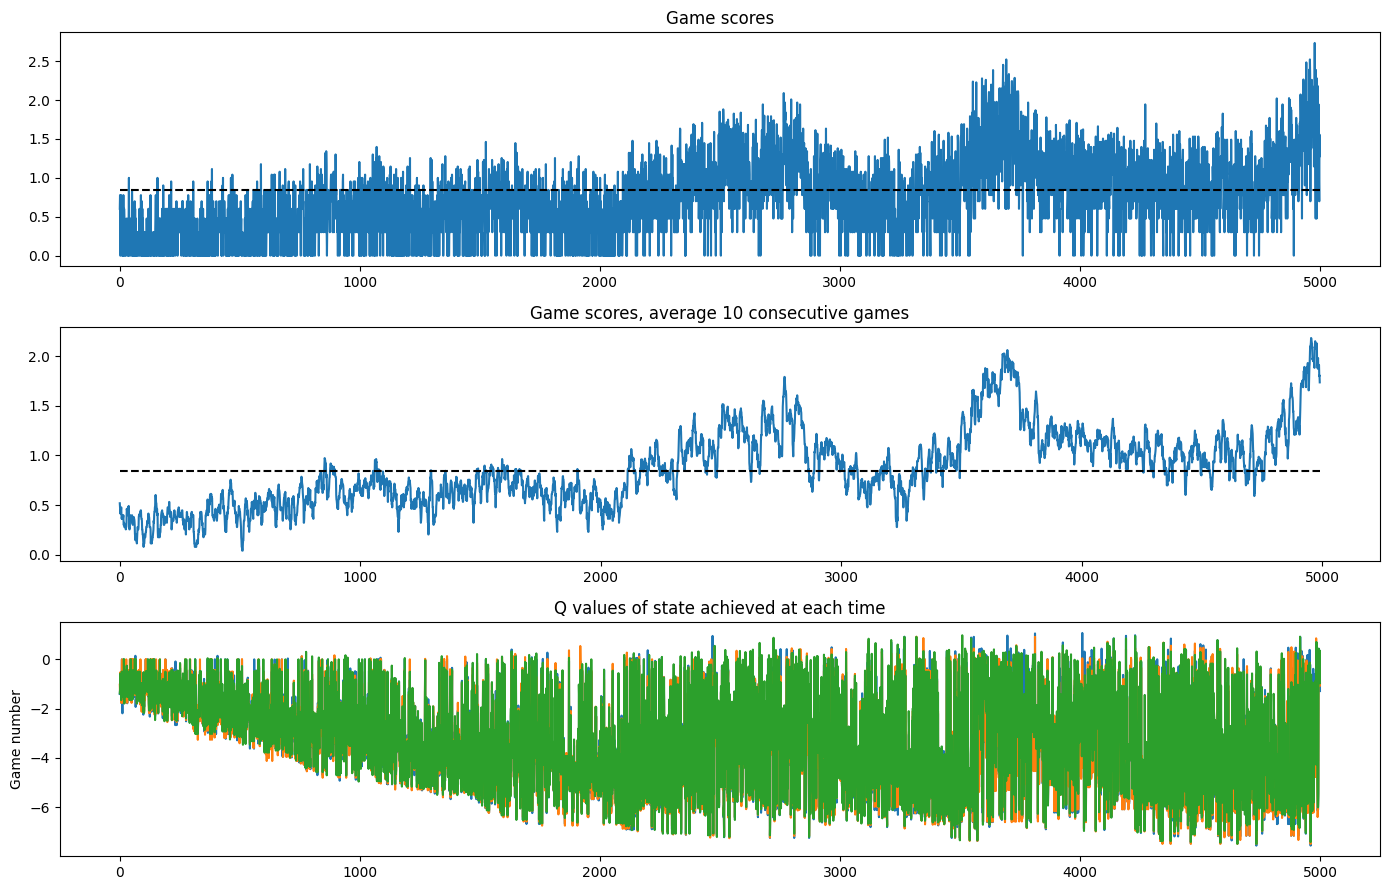

In [58]:
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14,9),layout='tight')
ax = [ fig.add_subplot(3,1,x) for x in range(1,4) ]
ax[0].plot(np.arange(0,len(scores)),np.log10(1+np.array(scores)))
ax[0].plot([0,5000],np.log10([7,7]),'k--')
ax[0].set_title('Game scores')
ax[1].plot(np.arange(4991),np.log10(1+np.convolve(np.ones(10)/10,scores,mode='valid')))
ax[1].plot([0,4991],np.log10([7,7]),'k--')
ax[1].set_title('Game scores, average 10 consecutive games')
ax[2].plot(np.arange(0,len(q_achieved)),q_achieved)
ax[2].set_title('Q values of state achieved at each time')
ax[2].set_ylabel('Game number')

Hooray, it has learned!  If you are getting a ten-game average score of better than 6, then you are ready to submit your model for grading.   In order to do that, you need to save the model:

In [59]:
q_learner.save('trained_model.npz')

<a id='section9'></a>

## Extra Credit

For extra credit, download the file <a href="mp11_extra.zip">mp11_extra.zip</a>.  The only important file in this package is:
* `tests/test_extra.py`: this contains extra tests that will evaluate your pre-trained `deep_q` learner, which should be in a file called `trained_model.pkl`.  For full credit, your model should achieve an average score of greater than 20, averaged over 10 consecutive games. 

With a quantized lookup table, it's probably not possible to achieve an average score of 20.  With a deep-Q learner, however, it is eminently possible.  In order to do the extra credit, therefore, you should just fill in the part of `submitted.py` that implements the `deep_q` learner, using pytorch to define a model structure, train it, save it, load it, and act on it.  This learner only needs to have five methods: `__init__`, `act`, `learn`, `save`, and `load`:

In [47]:
importlib.reload(submitted)
help(submitted.deep_q.__init__)

Help on function __init__ in module submitted:

__init__(self, alpha, epsilon, gamma, nfirst)
    Create a new deep_q learner.
    Your q_learner object should store the provided values of alpha,
    epsilon, gamma, and nfirst.
    It should also create a deep learning model that will accept
    (state,action) as input, and estimate Q as the output.
    
    @params:
    alpha (scalar) - learning rate of the Q-learner
    epsilon (scalar) - probability of taking a random action
    gamma (scalar) - discount factor
    nfirst (scalar) - exploring each state/action pair nfirst times before exploiting
    
    @return:
    None



In [48]:
help(submitted.deep_q.act)

Help on function act in module submitted:

act(self, state)
    Decide what action to take in the current state.
    You are free to determine your own exploration/exploitation policy -- 
    you don't need to use the epsilon and nfirst provided to you.
    
    @params: 
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y.
    
    @return:
    -1 if the paddle should move upward
    0 if the paddle should be stationary
    1 if the paddle should move downward



In [49]:
help(submitted.deep_q.learn)

Help on function learn in module submitted:

learn(self, state, action, reward, newstate)
    Perform one iteration of training on a deep-Q model.
    
    @params:
    state: a list of 5 floats: ball_x, ball_y, ball_vx, ball_vy, paddle_y
    action: an integer, one of -1, 0, or +1
    reward: a reward; positive for hitting the ball, negative for losing a game
    newstate: a list of 5 floats, in the same format as state
    
    @return:
    None



In [50]:
help(submitted.deep_q.save)

Help on function save in module submitted:

save(self, filename)
    Save your trained deep-Q model to a file.
    This can save in any format you like, as long as your "load" 
    function uses the same file format.
    
    @params:
    filename (str) - filename to which it should be saved
    @return:
    None



In [51]:
help(submitted.deep_q.load)

Help on function load in module submitted:

load(self, filename)
    Load your deep-Q model from a file.
    This should load from whatever file format your save function
    used.
    
    @params:
    filename (str) - filename from which it should be loaded
    @return:
    None



<a id='grade'></a>

## Grade your homework

If you've reached this point, and all of the above sections work, then you're ready to try grading your homework!  Before you submit it to Gradescope, try grading it on your own machine.  This will run some visible test cases (which you can read in `tests/test_visible.py`), and compare the results to the solutions (which you can read in `solution.json`).

The exclamation point (!) tells python to run the following as a shell command.  Obviously you don't need to run the code this way -- this usage is here just to remind you that you can also, if you wish, run this command in a terminal window.

In [60]:
!python grade.py

Completed 0 games, 24 rewards, 3777 frames, score 23, max score 23
Completed 1 games, 71 rewards, 15545 frames, score 46, max score 46
Completed 2 games, 94 rewards, 23984 frames, score 22, max score 46
Completed 3 games, 122 rewards, 28803 frames, score 27, max score 46
Completed 4 games, 124 rewards, 29300 frames, score 1, max score 46
Completed 5 games, 161 rewards, 35529 frames, score 36, max score 46
Completed 6 games, 162 rewards, 35710 frames, score 0, max score 46
Completed 7 games, 180 rewards, 41616 frames, score 17, max score 46
Completed 8 games, 220 rewards, 48023 frames, score 39, max score 46
Completed 9 games, 229 rewards, 50960 frames, score 8, max score 46


......
----------------------------------------------------------------------
Ran 6 tests in 0.901s

OK


Now you should try uploading your code to <a href="https://www.gradescope.com/courses/486387">Gradescope</a>.  

**Warning:** For this MP you need to update two files, not just one. 
* `trained_model.npz` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.

**Warning:** The autograder calculates the average score over ten random games.  If you are getting an average score above 10 almost all the time on your own computer, and if the autograder says you had a score below 10, try resubmitting to see if the next round of random games is better.

**Extra Credit:** Your extra credit should also be uploaded as two files,
* `trained_model.pkl` should contain your trained model
* `submitted.py` should contain your code that loads and runs your trained model.